In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [2]:
# read in csv wine file
df = pd.read_csv('winequality-red.csv')
df.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


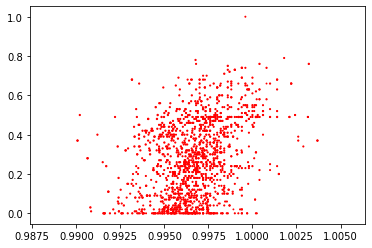

In [3]:
# take a look at how some of the variables look on a plot, looks kind of linear
plot.scatter(df.density,df.citricAcid,df.quality,marker='.',color='red')

In [4]:
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(df[['fixedAcidity','volatileAcidity','citricAcid','residualSugar','chlorides','freeSulfurDioxide','totalSulfurDioxide','density','pH','sulphates','alcohol']],df.quality,train_size=0.99)

In [5]:
x_train.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol
1349,6.9,0.57,0.00,2.8,0.081,21.0,41.0,0.99518,3.41,0.52,10.8
447,9.3,0.48,0.29,2.1,0.127,6.0,16.0,0.99680,3.22,0.72,11.2
175,6.9,0.50,0.04,1.5,0.085,19.0,49.0,0.99580,3.35,0.78,9.5
703,7.5,0.38,0.48,2.6,0.073,22.0,84.0,0.99720,3.32,0.70,9.6
836,6.7,0.28,0.28,2.4,0.012,36.0,100.0,0.99064,3.26,0.39,11.7


In [6]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
y_pred = np.round(reg.predict(x_test))
y_pred

array([5., 6., 6., 5., 6., 5., 5., 6., 5., 6., 5., 6., 6., 6., 5., 5.])

In [8]:
# error is inconsistent and all over the place. maybe quality isnt too correlated with the variables?
# highest error was ~1.5 and lowest was ~0.2
error = mean_squared_error(y_test,y_pred)
error

0.5625

In [9]:
# try rfe?
rfeModel = LinearRegression()
rfe3 = RFE(rfeModel,3)
rfe4 = RFE(rfeModel,4)
rfe5 = RFE(rfeModel,5)
rfe6 = RFE(rfeModel,6)
rfe7 = RFE(rfeModel,7)
rfe3 = rfe3.fit(x_train, np.ravel(y_train))
rfe4 = rfe4.fit(x_train, np.ravel(y_train))
rfe5 = rfe5.fit(x_train, np.ravel(y_train))
rfe6 = rfe6.fit(x_train, np.ravel(y_train))
rfe7 = rfe7.fit(x_train, np.ravel(y_train))

In [10]:
# results are still pretty inconsistent.
print('RFE3: {}\nRFE4: {}\nRFE5: {}\nRFE6: {}\nRFE7: {}'
      .format(
       rfe3.score(x_test, y_test),
       rfe4.score(x_test, y_test),
       rfe5.score(x_test, y_test),
       rfe6.score(x_test, y_test),
       rfe7.score(x_test, y_test),))

RFE3: 0.0836522034125885
RFE4: 0.08006011688793811
RFE5: 0.21787739614435708
RFE6: 0.2178784538313452
RFE7: 0.21676813746581158
